In [1]:
from utils import MLP, base_cost, get_episode, policy_objective, baseline_objective, sample_action, transform_action, systems, process_system, action_logprob, get_episode_cost
from jax import jit
from functools import partial
from tqdm.auto import tqdm
from datetime import timedelta as td, datetime as dt

import jax.numpy as jnp
import optax
import jax
import matplotlib.pyplot as plt

In [2]:
key = jax.random.PRNGKey(1)

In [73]:
sys_name = "REG"
system_info=systems[sys_name]
# target=dict(YD_r=1.2, C=0.8)
target=dict(Y=0.2,)

In [74]:
parameters = dict(
    policy_hidden_dims=[256],
    policy_seed=jnp.array([123, 123], dtype="u4"),
    policy_lr=3e-4,
    baseline_hidden_dims=[256],
    baseline_seed=jnp.array([123, 123], dtype="u4"),
    baseline_lr=3e-4,
    policy_sigma=15e-2,
    n_epochs=512,
    seed=jnp.array([124, 123], dtype="u4"),
    n_steps=64,
    eval_seed=jnp.array([101, 101], dtype="u4"),
    eval_n_episodes=256,
    eval_freq=32,
    train_n_episodes=1024,
)

In [75]:
system_data = process_system(system_info)
update = system_data["update"]

state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

In [76]:
state_dim, action_dim, len(system_params)

(26, 4, 12)

In [43]:
initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

In [44]:
var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
var_targ = jnp.array(list(target.values()))
cost = jit(partial(base_cost, i=var_idx, t=var_targ))

In [45]:
policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

In [46]:
get_raw_action = jit(policy_model.apply)
policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
policy_opt_state = policy_opt.init(policy_params)

baseline_model = MLP(dims=[*parameters["baseline_hidden_dims"], 1])
baseline_params = baseline_model.init(parameters["baseline_seed"], jnp.empty(state_dim))

get_baseline = jit(baseline_model.apply)

baseline_opt = optax.adam(learning_rate=parameters["baseline_lr"])
baseline_opt_state = baseline_opt.init(baseline_params)

action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

baseline_obj_and_grad = jax.value_and_grad(
    lambda params, states, tail_costs: baseline_objective(
        get_baseline(params, states).squeeze(),
        tail_costs
    )
)

policy_obj_and_grad = jax.value_and_grad(lambda params, states, actions, r: policy_objective(
    r, action_logprob(
        transform_action(
            get_raw_action(params, states),
            action_transforms
        ),
        actions,
        sigma
    )
))

In [47]:
sigma = parameters["policy_sigma"]

In [48]:
# initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))
n_episodes = 1024 * 32
initial_state = initial_state_stub(jax.random.uniform(parameters["seed"], (1, state_dim)))
eval_states = jnp.repeat(initial_state, 1024 * 16, axis=0)
initial_states = jnp.repeat(initial_state, n_episodes, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

1: cost 0.477351
2: cost 0.477120
3: cost 0.476863
4: cost 0.476598
5: cost 0.476320
6: cost 0.476025
7: cost 0.475735
8: cost 0.475478
9: cost 0.475167
10: cost 0.474793


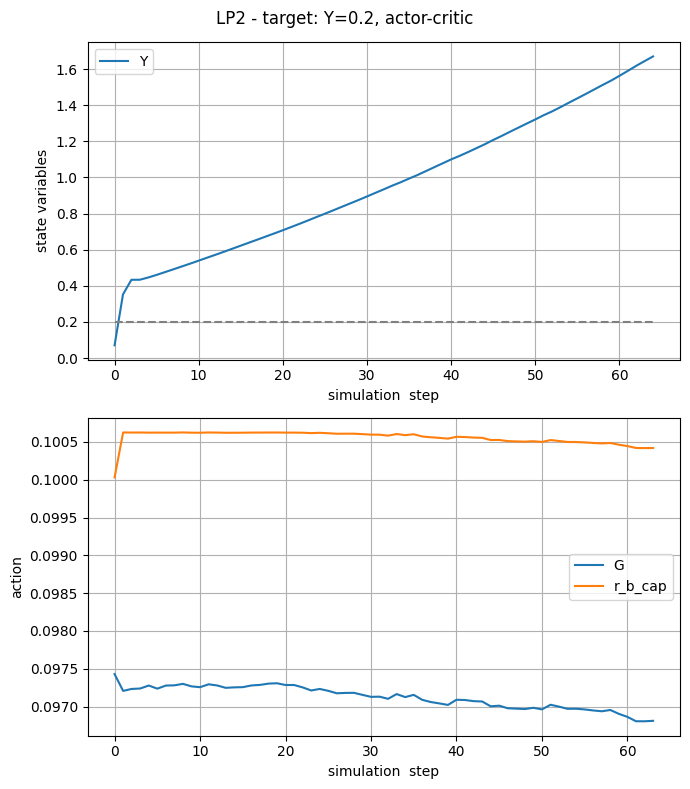

In [49]:
n_epochs = 10

n_steps = parameters["n_steps"]

get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
action_sampler = lambda params, state, key: sample_action(get_action(params, state), sigma, key, action_postprocess)

for i in tqdm(range(n_epochs)):
    key, seed = jax.random.split(key)
    states, actions = get_episode(update, system_params, action_sampler, policy_params, initial_states, n_steps, seed)

    tail_costs = jnp.cumsum(cost(states[:,1:])[:,::-1], axis=1)[:,::-1]
    states = states[:,:-1,:]

    r = tail_costs - get_baseline(baseline_params, states).squeeze()

    val, grad = baseline_obj_and_grad(baseline_params, states, tail_costs)
    updates, baseline_opt_state = baseline_opt.update(grad, baseline_opt_state)
    baseline_params = optax.apply_updates(baseline_params, updates)

    val, grad = policy_obj_and_grad(policy_params, states, actions, r)
    updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
    policy_params = optax.apply_updates(policy_params, updates)

    # if (i+1) % 10 == 0:
    #     print(val)

    if (i+1) % 1 == 0:
        # last_eval_time = cur_time
        eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
        print(f"{i+1}: cost {eval_cost:.6f}")

action_sampler = lambda params, state, key: sample_action(get_action(params, state), 0.0, key, action_postprocess)
states, actions = get_episode(update, system_params, action_sampler, policy_params, eval_states, n_steps, seed)

fig, ax = plt.subplots(nrows=2, figsize=(7, 8), tight_layout=True)

target_str = " ".join(map(lambda kv: f"{kv[0]}={kv[1]}", target.items()))
fig.suptitle(f"{sys_name} - target: {target_str}, actor-critic")

label = list(target.keys())
ax[0].plot(states[1,:,var_idx].T, label=label if len(label) > 1 else label[0])
ax[0].hlines(target.values(), xmin=0, xmax=n_steps, color='grey', linestyles='--')
ax[0].set_xlabel("simulation  step")
ax[0].set_ylabel("state variables")
ax[0].legend()
ax[0].grid()

# ax[1].set_title(f"test_sample_{sample_idx[0]} action")
ax[1].plot(actions[1], label=system_data["action_vars"])
ax[1].set_xlabel("simulation  step")
ax[1].set_ylabel("action")
ax[1].legend()
ax[1].grid()

In [60]:
action_sampler = lambda p, s, k: jax.random.uniform(k, shape=(1,action_dim,))
states, actions = get_episode(update, system_params, action_sampler, policy_params, initial_state, n_steps, seed)

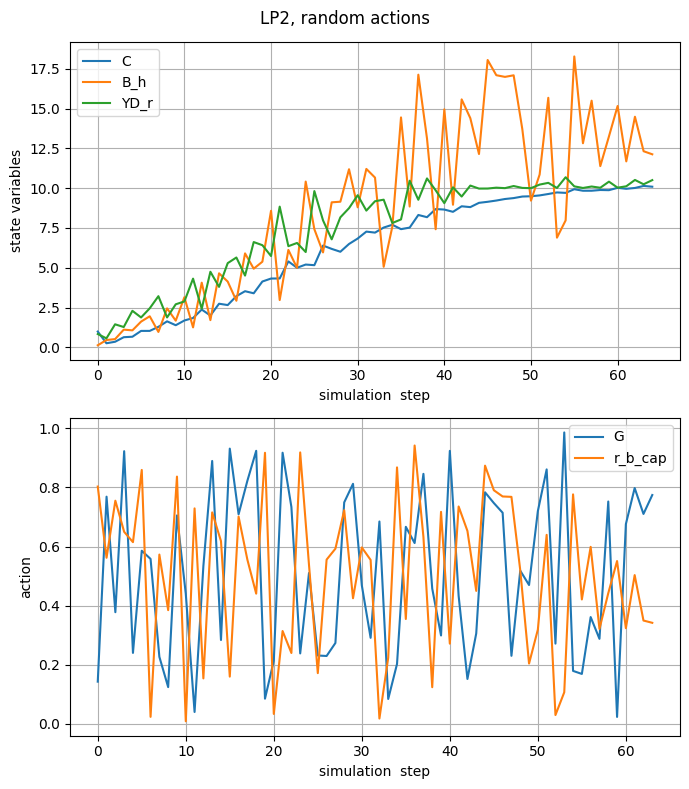

In [66]:
fig, ax = plt.subplots(nrows=2, figsize=(7, 8), tight_layout=True)

target = dict(C=0, B_h=0, YD_r=0)
var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
var_targ = jnp.array(list(target.values()))

# target_str = " ".join(map(lambda kv: f"{kv[0]}={kv[1]}", target.items()))
fig.suptitle(f"{sys_name}, random actions")

label = list(target.keys())
ax[0].plot(states[1,:,var_idx].T, label=label if len(label) > 1 else label[0])
ax[0].set_xlabel("simulation  step")
ax[0].set_ylabel("state variables")
ax[0].legend()
ax[0].grid()

# ax[1].set_title(f"test_sample_{sample_idx[0]} action")
ax[1].plot(actions[1], label=system_data["action_vars"])
ax[1].set_xlabel("simulation  step")
ax[1].set_ylabel("action")
ax[1].legend()
ax[1].grid()

In [67]:
fig.savefig("lp2_rand_acts.png")